bboxの縦方向の長さが正解ラベルとどれほど誤差があるか検証する

In [1]:
import pandas as pd
import numpy as np
import argparse
import sys
sys.path.append("/Users/hirototakaura/opt/anaconda3/lib/python3.8/site-packages")
from osgeo import gdal, ogr
from geopy.distance import geodesic
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import seaborn as sns

In [2]:
%matplotlib inline

In [3]:
'''
LINESTRINGからPLOYGONに変換する関数
line : 変換対象のオブジェクト
df: 変換対象のオブジェクトを含むdataframe
crt : 変換対象のオブジェクトを含む行番号
wrtcol: 書き込む列名
'''
def makePolygon(line, df, crt, wrtcol):
    ring = ogr.Geometry(ogr.wkbLinearRing)
    list_x = []
    list_y = []
    #lineの座標をリストに
    for count in range(line.GetPointCount()): 
        cood = line.GetPoint(count)
        list_x.append(cood[0])
        list_y.append(cood[1])
    #stringlineに点を追加
    for x, y in zip(list_x, list_y):
        ring.AddPoint(x, y)
    
    poly = ogr.Geometry(ogr.wkbPolygon)
    poly.AddGeometry(ring)
    #line1を着目しているラインに書き換える
    df.at[crt, wrtcol] = poly
    #print("make polygon in df{}".format(crt))
   

def LineToPoly(line):
    ring = ogr.Geometry(ogr.wkbLinearRing)
    list_x = []
    list_y = []
    #lineの座標をリストに
    for count in range(line.GetPointCount()): 
        cood = line.GetPoint(count)
        list_x.append(cood[0])
        list_y.append(cood[1])
    #stringlineに点を追加
    for x, y in zip(list_x, list_y):
        ring.AddPoint(x, y)
    
    poly = ogr.Geometry(ogr.wkbPolygon)
    poly.AddGeometry(ring)
    
    return poly

In [4]:
label_path = '../RodeOutline_HigasiOsaka/bbox/label/gmap_m_0001_6000_label.csv'
box_rem = '../RodeOutline_HigasiOsaka/bbox/bbox-csv/gmap_m_0001_6000_out-SDrmvd.csv'

In [5]:
label = pd.read_csv(label_path)
box = pd.read_csv(box_rem, index_col = 1).dropna(how='any')
#labelにポリゴンを追加
label["WKT"] = label["WKT"].map(lambda x:ogr.CreateGeometryFromWkt(x))
label['Polygon'] = label['WKT'].map(lambda x: LineToPoly(x))
box["WKT"] = box["WKT"].map(lambda x:ogr.CreateGeometryFromWkt(x))
box['Polygon'] = box['WKT'].map(lambda x: LineToPoly(x))
#boxにペアの長辺と短辺それぞれの差を計算して追加
#labelに長辺と短辺を追加
vertex = {'x1y1':[], 'x2y2':[], 'x3y3':[], 'x4y4':[]}
for id in label.index.to_numpy():
    line = label['WKT'][id]
    pts = []
    for count in range(line.GetPointCount()):
        pts.append(line.GetPoint(count)[:-1])
    vertex['x1y1'].append(pts[0])
    vertex['x2y2'].append(pts[1])
    vertex['x3y3'].append(pts[2])
    vertex['x4y4'].append(pts[3])

label = label.join(pd.DataFrame(vertex))

FullLength = []
WideLength = []
for id in label.index.to_numpy():
    pair1 = label['x1y1'][id]
    pair2 = label['x2y2'][id]
    pair3 = label['x3y3'][id]

    #(Longtitude, Latitude) -> (Latitude, Longtitude)
    pair1 = [pair1[1], pair1[0]]
    pair2 = [pair2[1], pair2[0]]
    pair3 = [pair3[1], pair3[0]]

    l1 = geodesic(pair1, pair2).m
    l2 = geodesic(pair2, pair3).m
    if l1 >= l2:
        FullLength.append(l1)
        WideLength.append(l2)
    else:
        FullLength.append(l2)
        WideLength.append(l1)
        
label['FullLength'] = FullLength
label['WideLength'] = WideLength

In [6]:
#ペアリング
boxout = box.copy()
boxlabel = label.copy()
#evaluation
boxout.loc[:, 'TP'] = False
boxout.loc[:, 'FP'] = False
boxout.loc[:, 'pairTo'] = -1
boxlabel.loc[:, 'TP'] = False
boxlabel.loc[:, 'FN'] = False
boxlabel.loc[:, 'pairTo'] = -1
#出力された各boxについてマッチングする正解ラベルを探索
for col1 in boxout.index.to_numpy():
    out_box = boxout['Polygon'][col1]
    for col2 in boxlabel.index.to_numpy():
        label_box = boxlabel['Polygon'][col2]
        intersection = out_box.Intersection(label_box)
        if intersection is None:
            print(col1, col2)
        if not intersection.IsEmpty():#boxとlabelが重なってるか
            s1 = out_box.Union(label_box).GetArea()
            s2 = intersection.GetArea() 
            iou = s2 / s1
            if iou >= 0.3 and boxlabel['pairTo'][col2] == -1: #0.3以上ならTPとする
                boxout.at[col1, 'TP'] = True
                boxout.at[col1, 'pairTo'] = col2
                boxlabel.at[col2, 'TP'] = True
                boxlabel.at[col2, 'pairTo'] = col1
                break
            else:
                continue
        else:
            continue
    #マッチングしなかったboxoutはFP
    if boxout['pairTo'][col1] == -1:
        boxout.at[col1, 'FP'] = True
#マッチングしなかったlabelはFN
boxlabel.loc[boxlabel['pairTo'] == -1, 'FN'] = True

TP = len(boxout[boxout['TP'] == True])
FP = len(boxout[boxout['FP'] == True])
FN = len(boxlabel[boxlabel['FN'] == True])

accuracy = TP / (TP + FP + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
Fmeasure = (2 * precision * recall) / (precision + recall)
print('done')

done


In [7]:
#boxにペアの長辺と短辺それぞれの差を計算して追加
diffs = []

for id in boxout.index.to_numpy():
    l1 = boxout['FullLength'][id]
    l2 = boxlabel['FullLength'][boxout['pairTo'][id]]
    diff = l1 - l2
    diffs.append(diff)
boxout['diff'] = diffs

In [8]:
boxout

,field_1,WKT,x1y1,x2y2,x3y3,x4y4,classname,score,Polygon,L1,L2,FullLength,WideLength,TP,FP,pairTo,diff
Unnamed: 0,,,,,,,,,,,,,,,,,
0,0,LINESTRING (135.591836540229 34.6826261767757 ...,"[135.5918365402292, 34.68262617677573]","[135.59181688627982, 34.68262617677573]","[135.59181688627982, 34.68266699344335]","[135.5918365402292, 34.68266850517178]",small-vehicle,0.993552,"POLYGON ((135.591836540229 34.6826261767757 0,...",1.801073,4.527988,4.527988,1.801073,True,False,304,0.059886
1,1,LINESTRING (135.589905917661 34.6850661064623 ...,"[135.58990591766144, 34.68506610646232]","[135.58990440581917, 34.685046453992726]","[135.5898560268668, 34.685046453992726]","[135.5898560268668, 34.68506610646232]",small-vehicle,0.993299,"POLYGON ((135.589905917661 34.6850661064623 0,...",2.184541,4.433281,4.433281,2.184541,True,False,13,-0.214915
3,3,LINESTRING (135.591841075756 34.6828211897432 ...,"[135.59184107575598, 34.682821189743244]","[135.59181839812206, 34.682821189743244]","[135.59181688627982, 34.68286502986773]","[135.59183956391374, 34.68286502986773]",small-vehicle,0.990027,"POLYGON ((135.591841075756 34.6828211897432 0,...",2.078156,4.865367,4.865367,2.078156,True,False,302,0.206958
4,4,LINESTRING (135.590282366385 34.6834379749428 ...,"[135.5902823663845, 34.68343797494283]","[135.59026120059286, 34.68343797494283]","[135.59026120059286, 34.68347879161045]","[135.5902823663845, 34.68347879161045]",small-vehicle,0.989908,"POLYGON ((135.590282366385 34.6834379749428 0,...",1.939598,4.527988,4.527988,1.939598,True,False,240,0.067723
5,5,LINESTRING (135.594826964222 34.6850464539927 ...,"[135.59482696422222, 34.685046453992726]","[135.59480579843057, 34.68504040707901]","[135.59479219185022, 34.685082735475056]","[135.59481335764187, 34.68509029411721]",small-vehicle,0.989431,"POLYGON ((135.594826964222 34.6850464539927 0,...",2.052288,4.858415,4.858415,2.052288,True,False,389,-0.062739
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
632,589,LINESTRING (135.594137564151 34.6851008762162 ...,"[135.59413756415103, 34.68510087621622]","[135.5941345404665, 34.685129599056395]","[135.5942328102135, 34.68513715769855]","[135.594235833898, 34.68510843485837]",large-vehicle,0.246048,"POLYGON ((135.594137564151 34.6851008762162 0,...",3.198388,9.044049,9.044049,3.198388,True,False,72,0.412389
633,590,LINESTRING (135.595050716877 34.6802421810411 ...,"[135.5950507168769, 34.68024218104106]","[135.5950507168769, 34.680261833510656]","[135.59511421425188, 34.68026485696752]","[135.59511421425188, 34.68024520449792]",large-vehicle,0.245237,"POLYGON ((135.595050716877 34.6802421810411 0,...",2.180141,5.828675,5.828675,2.180141,True,False,220,-1.740520
638,593,LINESTRING (135.590383659816 34.6806639532731 ...,"[135.590383659816, 34.68066395327313]","[135.59036400586663, 34.68066395327313]","[135.59036400586663, 34.68071081685447]","[135.590383659816, 34.68071081685447]",large-vehicle,0.212057,"POLYGON ((135.590383659816 34.6806639532731 0,...",1.801115,5.198799,5.198799,1.801115,True,False,277,1.841833


In [9]:
boxout.loc[:, ['FullLength', 'WideLength', 'pairTo', 'diff']].describe()

,FullLength,WideLength,pairTo,diff
count,444.000000,444.000000,444.000000,444.000000
mean,5.417214,2.204419,221.500000,0.159103
std,2.270841,0.439706,128.316016,0.382302
min,3.204018,1.451581,0.000000,-1.740520
25%,4.158906,1.939584,110.750000,-0.060876
50%,4.696713,2.078199,221.500000,0.134178
75%,5.272656,2.351929,332.250000,0.362066
max,17.540084,3.692073,443.000000,2.746776


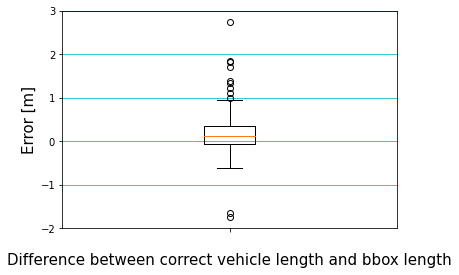

In [11]:
math = boxout['diff']
# 国語の点数
# 点数のタプル
points = (math)

# 箱ひげ図
fig, ax = plt.subplots()

bp = ax.boxplot(points)
ax.set_xticklabels(['Difference between correct vehicle length and bbox length'], fontsize=15, y = -0.08)

#plt.title('Box plot')
#plt.xlabel('exams')
plt.ylabel('Error [m]', fontsize=15)
# Y軸のメモリのrange
plt.ylim([-2,3])
ax.grid(color = 'c', axis='y')

# 描画
plt.show()

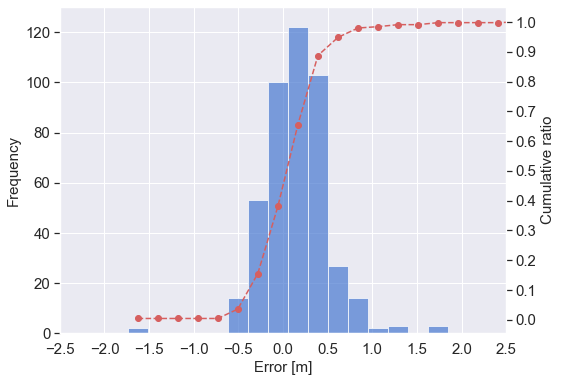

In [32]:
# seabornのスタイルでプロット
sns.set(style="darkgrid", palette="muted", color_codes=True)
#dt = np.array(carinfo_out['Speed'])
#dt = np.array(carinfo_in['Speed'])
dt = np.array(boxout['diff'])

fig, ax1 = plt.subplots(figsize=(8, 6))

# ヒストグラムプロットとビン情報の取得
n, bins, patches = ax1.hist(dt, bins=20, alpha=0.7, label='Frequency', rwidth=1)

# 第2軸用値の算出
y2 = np.add.accumulate(n) / n.sum()
x2 = np.convolve(bins, np.ones(2) / 2, mode="same")[1:]
plt.xticks(np.arange(-2.5, 3.0, 0.5), fontsize = 15)
plt.yticks(np.arange(0, 220, 20), fontsize = 15)

# 第2軸のプロット
ax2 = ax1.twinx()
lines = ax2.plot(x2, y2, ls='--', color='r', marker='o',
         label='Cumulative ratio')
ax2.grid(visible=False)
plt.yticks(np.arange(0, 1.1, 0.1), fontsize = 15)

ax1.set_xlabel('Error [m]', fontsize=15, y=-0.23)
ax1.set_ylabel(r'Frequency', fontsize=15)
ax2.set_ylabel(r'Cumulative ratio', fontsize=15)
#軸目盛り
ax1.set_xlim(-2.5,2.5)
ax1.set_ylim(0,130)

plt.show()
